# Model fits using `emcee` for parameter uncertainty estimates

Note that `emcee` is not used for the model fits themselves, which we do first using `lmfit` with another method (e.g., Levenberg–Marquardt or Nelder–Mead).

## Load libraries and define helper functions

In [2]:
import cmasher as cmr
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import lmfit
import json
import astropy.units as u
import bfunc
import pandas as pd
import corner

In [3]:
sns.set_color_codes()
sns.set_context("talk")

In [4]:
def values2arrays(d):
    for k in d.keys():
        if type(d[k]) == list:
            d[k] = np.array(d[k])
    return d

## Load example dataset and clean it up to be ready for fitting

Javier's workflow already does this in the `SFxxx.ipynb` notebooks and saves the cleaned up data in `SFresults/*.pkl`. But I am using my own Orion structure function from a JSON file, so I need to do the clean-up here.

In [104]:
with open("orion-strucfunc-ha.json") as f:
    sf = values2arrays(json.load(f))
mask = sf["N pairs"] > 0

# Translation from pixels to parsecs
Distance_pc = 410
pix_scale_arcsec = 0.534
pc_per_arcsec = (Distance_pc * (u.au / u.pc)).cgs.value
pix_scale_pc = pc_per_arcsec * pix_scale_arcsec

# Finite box size for Orion KPNO data
box_size = np.sqrt(356 * 512) * pix_scale_pc

# We want ro fit B(r)
r = 10**sf["log10 r"][mask]
r *= pix_scale_pc
B = sf["Unweighted B(r)"][mask]


## Set the parameters for the fit

We use `lmfit` to infer the parameter names from the model:

In [105]:
model = lmfit.Model(bfunc.bfunc04s)
model.param_names

['r0', 'sig2', 'm', 's0', 'noise', 'box_size']

We want `box_size` to be fixed, but the other parameters can vary.  By default, `lmfit` uses `emcee` with uniform priors within the allowed range of each parameter. I think that this means that we will need to give an explicit range for each.

In [106]:
# Correlation length between 1/10 and 2 x box_size
model.set_param_hint("r0", value=0.1 * box_size, min=0.01 * box_size, max=2 * box_size)

# sig2 between 1/4 and 2 x max value of B(r)
model.set_param_hint("sig2", value=0.5 * B.max(), min=0.25 * B.max(), max=2 * B.max())

# m between 1/2 and 5/3
model.set_param_hint("m", value=1.0, min=0.5, max=1.667)

# Seeing RMS between 0.1 and 1.5 arcsec
model.set_param_hint("s0", value=0.5 * pc_per_arcsec, min=0.1 * pc_per_arcsec, max=1.5 * pc_per_arcsec)

# Noise cannot be much larger than smallest B(r)
model.set_param_hint("noise", value=0.5 * B.min(), min=0.0, max=3 * B.min())

# box_size is fixed
model.set_param_hint("box_size", value=box_size, vary=False)

In [107]:
pd.DataFrame(model.param_hints)

,r0,sig2,m,s0,noise,box_size
value,0.045317,11.801099,1.000,0.000994,0.015019,0.453169
min,0.004532,5.900549,0.500,0.000199,0.000000,NaN
max,0.906338,47.204394,1.667,0.002982,0.090115,NaN
vary,NaN,NaN,NaN,NaN,NaN,False


## Set the weights for the fit

For the time being, carry on using the constant relative uncertainty. 

_But we really ought to implement the fourth order differences in the strucfunc calculation so we can calculate the errors properly_

In [108]:
relative_uncertainty = 0.02
weights = 1.0 / (relative_uncertainty * B)
large_scale = r > 0.5 * box_size
weights[large_scale] /= 8.0
weights[:3] /= 3.0

We increase the error bars for the first 3 points, since they have smaller number of pairs.  We exclude separations larger than half the box size from the fit.  I think this makes more sense than just increasing the errors there.

## Perform the fit and look at results

In [109]:
to_fit = ~large_scale
result_orion = model.fit(B[to_fit], weights=weights[to_fit], r=r[to_fit])

Look at the results. It seems that `lmfit` will now use a rich representation of the result to display in a notebook. 

In [110]:
result_orion

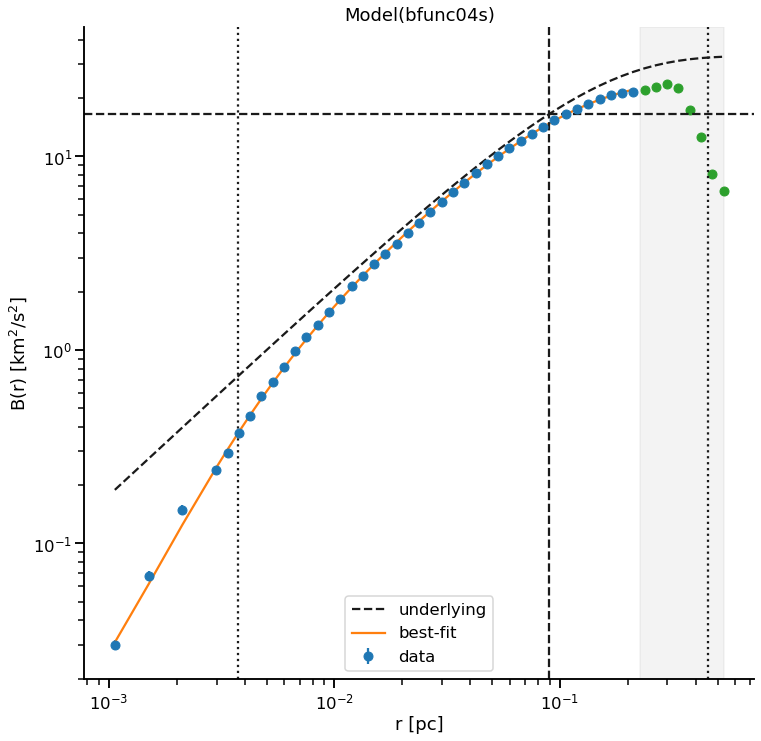

In [12]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the underlying model without instrumental effects
Bu = bfunc.bfunc00s(r, result.params["r0"].value, result.params["sig2"].value, result.params["m"].value)
ax.plot(r, Bu, color="k", linestyle="dashed", label="underlying")

# Plot the fit results
result.plot_fit(ax=ax)

# Add in the points not included in fit
ax.plot(r[large_scale], B[large_scale], "o")

# Dotted lines for 2 x rms seeing and for box size
ax.axvline(2 * result.params["s0"].value, color="k", linestyle="dotted")
ax.axvline(result.params["box_size"].value, color="k", linestyle="dotted")

# Dashed lines for best-fit r0 and sig2
ax.axvline(result.params["r0"].value, color="k", linestyle="dashed")
ax.axhline(result.params["sig2"].value, color="k", linestyle="dashed")

# Gray box to indicate the large scale values that are excluded from the fit
ax.axvspan(result.params["box_size"].value / 2, r[-1], color="k", alpha=0.05, zorder=-1)

ax.set(
    xscale = "log",
    yscale = "log",
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
)
sns.despine();


## Now try out emcee

The procedure is copied from [this example in the lmfit docs](https://lmfit.github.io/lmfit-py/examples/example_emcee_Model_interface.html). 

In [111]:
emcee_kws = dict(steps=5000, burn=500, thin=50, is_weighted=True,
                 progress=False, workers=16)
emcee_params = result_orion.params.copy()
# emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

The extra parameter `__lnsigma` is a scaling factor for the errors, _but I am not using it any more_. It does not seem to be compatible with using per-point weights in the fit.  And if we don't use the weights in the `emcee` run, then the solution is a long way from the one found in the initial fit.

I tried the following to get multiprocessing to work, but it does not help, so it is disabled.

In [14]:
#import os
#os.environ["OMP_NUM_THREADS"] = "1"

In [15]:
result_emcee_orion = model.fit(
    data=B[to_fit], r=r[to_fit], weights=weights[to_fit], params=emcee_params, method='emcee',
    nan_policy='omit', fit_kws=emcee_kws,
)

This takes about 1 minute to run.  Even with `workers=16` it doesn't seem to be using multiple threads on my laptop.

In [16]:
result_emcee_orion

Text(0, 0.5, 'acceptance fraction')

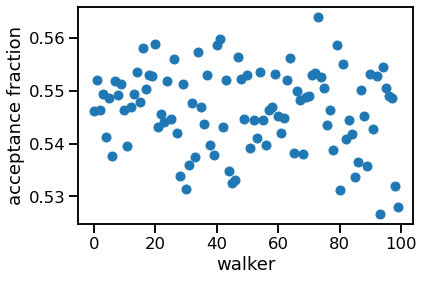

In [17]:
plt.plot(result_emcee_orion.acceptance_fraction, 'o')
plt.xlabel('walker')
plt.ylabel('acceptance fraction')

In [20]:
if hasattr(result_emcee_orion, "acor"):
    print("Autocorrelation time for the parameters:")
    print("----------------------------------------")
    for i, p in enumerate(result_emcee_orion.params):
        try:
            print(f'{p} = {result_emcee_orion.acor[i]:.3f}')
        except IndexError:
            pass

Autocorrelation time for the parameters:
----------------------------------------
r0 = 58.512
sig2 = 58.517
m = 56.095
s0 = 53.591
noise = 51.234


Make a dict of latex-formatted parameter names:

In [29]:
fancy_names = {
    "r0": "Corr. length:\n" + r"$r_0$ [parsec]",
    "sig2": "Vel. variance:\n" + r"$\sigma^2$ [km$^2$ s$^{-1}$]",
    "m": "Power-law slope:\n" + r"$m$",
    "s0": "RMS seeing:\n" + r"$s_0$ [parsec]",
    "noise": "Noise:\n" + r"[km$^2$ s$^{-1}$]",
}

In [177]:
def corner_plot(result_emcee, result_orig, suffix, data_ranges=None):
    # We need to remove the frozen parameters from the list before passing it as the truths argument
    truths = [_.value for _ in result_orig.params.values() if _.vary]    
    fig = corner.corner(
        result_emcee.flatchain, 
        labels=[fancy_names[_] for _ in result_emcee.var_names],
        truths=truths,
        labelpad=0.2,
        range=[0.995]*len(truths) if data_ranges is None else data_ranges,
        color="#b04060",
        hist_kwargs=dict(color="k"),
        data_kwargs=dict(color="k"),
    )
    sns.despine()
    fig.set_size_inches(15, 15)
    fig.tight_layout(h_pad=0, w_pad=0)
    fig.savefig(f"corner-emcee-{suffix}.pdf");    

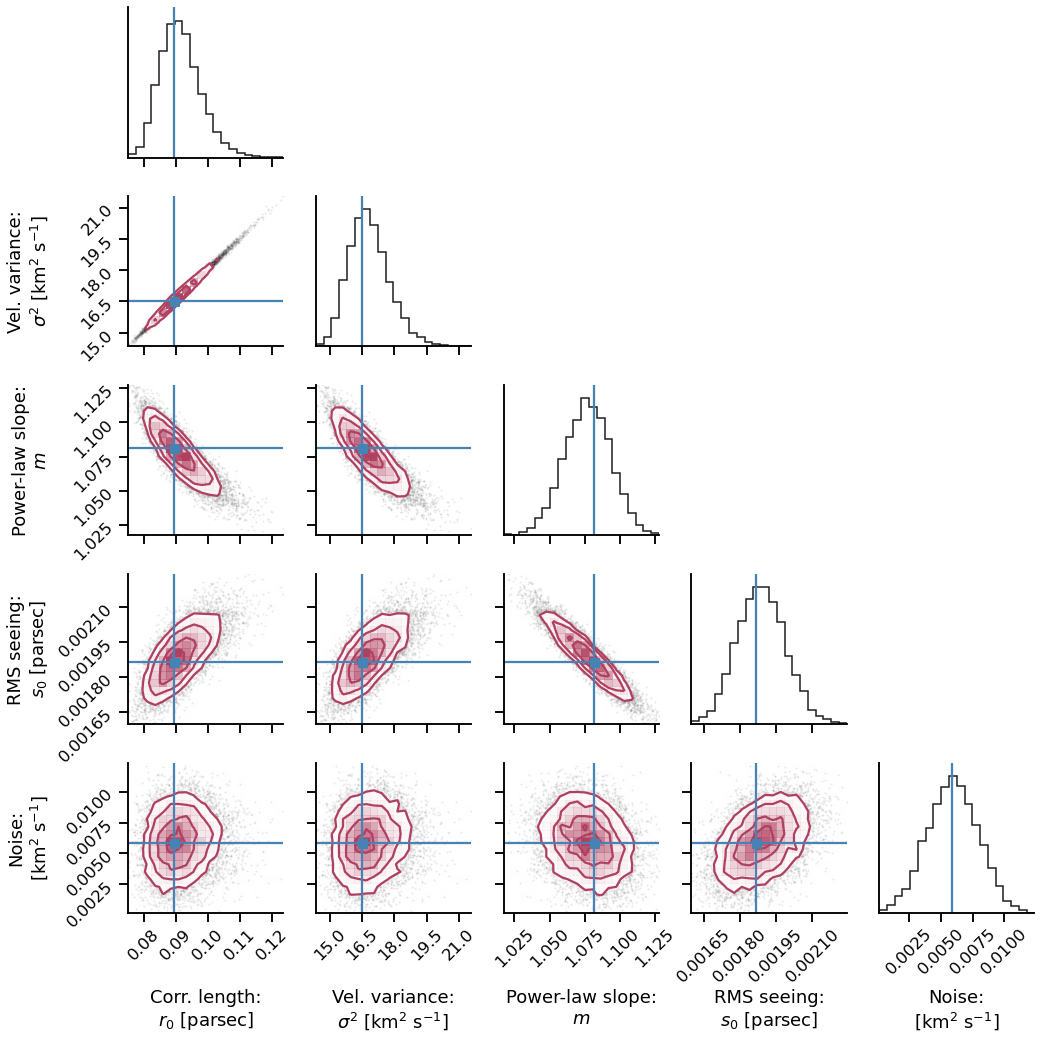

In [151]:
corner_plot(result_emcee_orion, result_orion, "orion");

This seems to work pretty well. Note that the "truth" parameters (shown in blue) are from the original LM fit.  In this case, the fit is very tight, so these are very close to the maximum likelihood of the emcee model. 

## Use the emcee chain to plot the range of possible models

In [31]:
span_kwds = dict(zorder=-1, linestyle="none")
def spread_span(
    ax, 
    values, 
    orient="h", 
    pranges=[[2.5, 97.5], [16, 84]], 
    alphas=[0.1, 0.3],
    colors=["m", "m"],
):
    """
    Show the spread of values as overlapping translucent boxes.
    A box is plotted for each percentile range in pranges
    Orientation (horizontal or vertical) is controlled by orient
    """
    for prange, alpha, color in zip(pranges, alphas, colors):
        if orient=="h":
            ax.axhspan(*np.percentile(values, prange), alpha=alpha, color=color, **span_kwds)
        else:
            ax.axvspan(*np.percentile(values, prange), alpha=alpha, color=color, **span_kwds)

# Opaque white box to use as bbox argument for labels (ax.text() or ax.annotate())
whitebox = dict(facecolor="white", pad=5, edgecolor="0.5", linewidth=0.5)
label_kwds = dict(ha="center", va="center", bbox=whitebox, zorder=100)
label_kwds2 = dict(ha="left", va="center", bbox=whitebox, zorder=100)

Define a function for making the strucfunc graphs to include in the paper.  This should have the following properties:
- [X] consistent set of graph limits based on the box size and maximum B.  This will allow us to more easily compare different sources.
- [X] Label all the things
- [X] Show uncertainties on the parameters
- [X] Show samples of the true and apparent model from the emcee walker chain

In [191]:
def strucfunc_plot(result_emcee, r, B, to_fit, source_name, suffix):

    xmin, xmax = 5e-4 * box_size, 8 * box_size
    ymin, ymax = 5e-4 * B.max(), 8 * B.max()    
    xarr = np.logspace(np.log10(xmin), np.log10(xmax))
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    best = result_emcee.best_values
    
    # Plot the data
    yerr = 1.0 / result_emcee.weights
    data_points = ax.errorbar(r[to_fit], B[to_fit], yerr=yerr, fmt="o")
    c_data = data_points[0].get_color()
    ax.annotate(
        "observed", 
        (r[3], B[3]), 
        xytext=(40, -20), 
        textcoords="offset points",
        color=c_data,
        arrowprops=dict(arrowstyle="->", color=c_data, shrinkB=8),
        **label_kwds2
    )

    # Plot the full model ˚including without instrumental effects
    Ba = bfunc.bfunc04s(xarr, **best)
    line_apparent = ax.plot(xarr, Ba)
    c_apparent = line_apparent[0].get_color()
    xa = 0.5 * (r[1] + r[2])
    ya = bfunc.bfunc04s(xa, **best)
    ax.annotate(
        "model",
        (xa, ya),
        xytext=(20, -40), 
        textcoords="offset points",
        color=c_apparent,
        arrowprops=dict(arrowstyle="->", color=c_apparent, shrinkB=8),
        **label_kwds2,
    )
    #ax.text(xmax / 1.5, Ba[-1], "model apparent", color=c_apparent, **label_kwds2)
    
    # Plot the underlying model without instrumental effects
    Bu = bfunc.bfunc00s(xarr, best["r0"], best["sig2"], best["m"])
    line_true = ax.plot(xarr, Bu, linestyle="dashed")
    c_true = line_true[0].get_color()
    ax.annotate(
        "model true",
        (xarr[10], Bu[10]),
        xytext=(-30, 60), 
        textcoords="offset points",
        color=c_true,
        arrowprops=dict(arrowstyle="->", color=c_true, shrinkB=8),
        **label_kwds,
    )
    #ax.text(xmax / 1.5, Bu[-1], "model true", color=c_true, **{**label_kwds2, "zorder": 99})
    
    
    # Plot the fit results
    # result_emcee.plot_fit(ax=ax)
    
    # Plot a random sample of the emcee chain
    inds = np.random.randint(len(result_emcee.flatchain), size=100)
    for ind in inds:
        sample = result_emcee.flatchain.iloc[ind]
        try: 
            s0 = sample.s0
        except AttributeError:
            s0 = best["s0"]
        Bsamp = bfunc.bfunc04s(xarr, sample.r0, sample.sig2, sample.m, s0, sample.noise, best["box_size"])
        ax.plot(xarr, Bsamp, alpha=0.05, color="orange")
        Busamp = bfunc.bfunc00s(xarr, sample.r0, sample.sig2, sample.m)
        ax.plot(xarr, Busamp, alpha=0.05, color="g")
    
    # Dotted lines for 2 x rms seeing and for box size
    ax.axvline(best["s0"], color="k", linestyle="dotted")
    try:
        spread_span(ax, result_emcee.flatchain.s0, orient="v")
    except AttributeError:
        # Case where s0 parameter is frozen
        pass
    #ax.text(best["s0"], 1.5 * ymin, r"$s_0$", **label_kwds)
    ax.annotate(
        r"$s_0$",
        (best["s0"], 1.5 * ymin),
        xytext=(-40, 0), 
        textcoords="offset points",
        color="k",
        arrowprops=dict(arrowstyle="->", color="k", shrinkB=2),
        **label_kwds,
    )
    
    ax.axvline(best["box_size"], color="k", linestyle="dotted")
    ax.text(best["box_size"], 1.5 * ymin, r"$L$", **label_kwds)
    
    # Dashed lines for best-fit r0 and sig2
    ax.axvline(best["r0"], color="k", linestyle="dashed")
    spread_span(ax, result_emcee.flatchain.r0, orient="v")
    # ax.text(best["r0"], 1.5 * ymin, r"$r_0$", **label_kwds)
    ax.annotate(
        r"$r_0$",
        (best["r0"], 1.5 * ymin),
        xytext=(40, 20), 
        textcoords="offset points",
        color="k",
        arrowprops=dict(arrowstyle="->", color="k", shrinkB=2),
        **label_kwds,
    )
    
    ax.axhline(best["sig2"], color="k", linestyle="dashed")
    spread_span(ax, result_emcee.flatchain.sig2, orient="h")
    ax.text(1.5 * xmin, best["sig2"], r"$\sigma^2$", **label_kwds)

    if np.any(~to_fit):
        # Add in the points not included in fit
        ax.plot(r[large_scale], B[large_scale], "o", color=c_data, mew=3, fillstyle="none")
        # Translucent overlay box to indicate the large scale values that are excluded from the fit
        ax.axvspan(box_size / 2, ymax, color="w", alpha=0.5, zorder=50)

        
    ax.text(np.sqrt(xmin * xmax), ymax / 1.5, source_name, fontsize="large", **label_kwds)
    ax.set(
        xscale = "log",
        yscale = "log",
        xlabel = "Separation: $r$ [pc]",
        ylabel = r"Structure function: $B(r)$ [km$^{2}$/s$^{2}$]",
        xlim = [xmin, xmax],
        ylim = [ymin, ymax],
    )
    sns.despine()
    fig.tight_layout()
    fig.savefig(f"sf-emcee-{suffix}.pdf");

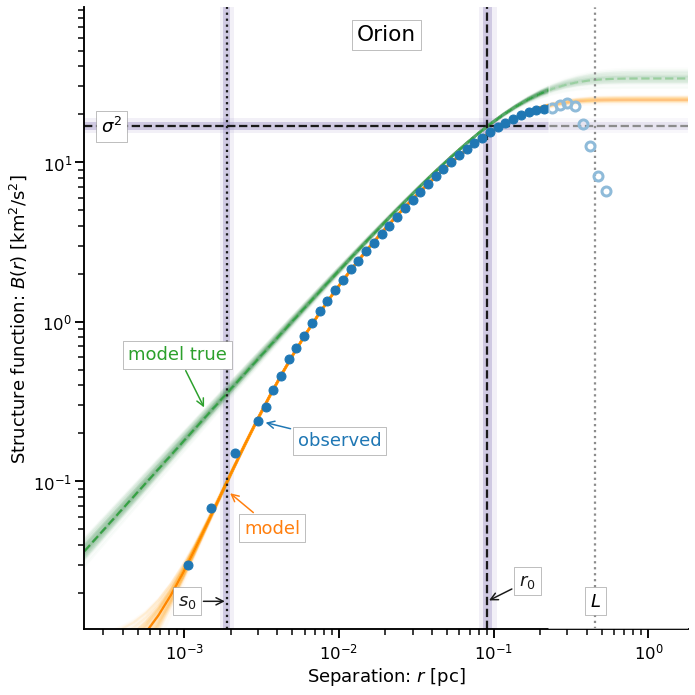

In [96]:
strucfunc_plot(result_emcee_orion, r, B, to_fit, "Orion", "orion")

The orange lines are a sampling of the chains for the full model.  The green lines are the same for the "true" model. 

## Repeat for a distant source

In [38]:
import pickle
from pathlib import Path

jav_path = Path("../JavierGVastro/PhD.Paper/")

I will first try NGC 604. Load the data from Javier's project:

In [165]:
with open(jav_path / "SFresults" / "N604H.pkl", "rb") as f:
    sfdata = pickle.load(f)
with open(jav_path / "VFM" / "N604H.pkl", "rb") as f:
    vfdata = pickle.load(f)

sf = sfdata["SF"]
mask = sf["N pairs"] > 0

Set up the source-specific length scales: pixel size and box size. 

In [166]:
# Translation from pixels to parsecs
Distance_pc = 840_000
pix_scale_arcsec = vfdata["pix"]
pc_per_arcsec = (Distance_pc * (u.au / u.pc)).cgs.value
pix_scale_pc = pc_per_arcsec * pix_scale_arcsec

# Finite box size
box_size = 120 * pix_scale_pc

# We want ro fit B(r)
r = 10**sf["log10 r"][mask]
r *= pix_scale_pc
B = sf["Unweighted B(r)"][mask]

Unlike with the Orion case, I found that it was necessary to freeze the seeing parameter for NGC 604.  I first tried letting the seeing vary, but the emcee sampler does not converge very well. _Update: I got the variable seeing case to ework a bit better, which is given below as `result_emcee_606`_

In [167]:
model = lmfit.Model(bfunc.bfunc04s)

# Correlation length between 1/10 and 2 x box_size
model.set_param_hint("r0", value=0.1 * box_size, min=0.01 * box_size, max=2 * box_size)

# sig2 between 1/4 and 2 x max value of B(r)
model.set_param_hint("sig2", value=0.5 * B.max(), min=0.25 * B.max(), max=2 * B.max())

# m between 0 and 2
model.set_param_hint("m", value=1.0, min=0.0, max=2.0)

# Seeing RMS fixed at FWHM = 1 arcsec
model.set_param_hint("s0", value=1.0 * pc_per_arcsec / 2.35, vary=False)
#model.set_param_hint("s0", value=0.5 * pc_per_arcsec, min=0.1 * pc_per_arcsec, max=1.5 * pc_per_arcsec)

# Noise cannot be much larger than smallest B(r)
model.set_param_hint("noise", value=0.5 * B.min(), min=0.0, max=3 * B.min())

# box_size is fixed
model.set_param_hint("box_size", value=box_size, vary=False)

relative_uncertainty = 0.15
weights = 1.0 / (relative_uncertainty * B)
large_scale = r > 0.5 * box_size
weights[large_scale] /= 3.0
#weights[:3] /= 3.0

to_fit = np.ones(B.shape, dtype=bool)
result_606 = model.fit(B[to_fit], weights=weights[to_fit], r=r[to_fit])

Another difference with Orion is that I am not excluding the points with $r > L/2$ in this case.  The reason for this is that there are not many points on the flat part of the structure function, so I cannot afford to exclude any.  This might be better using `dlogr=0.05`

In [168]:
result_606

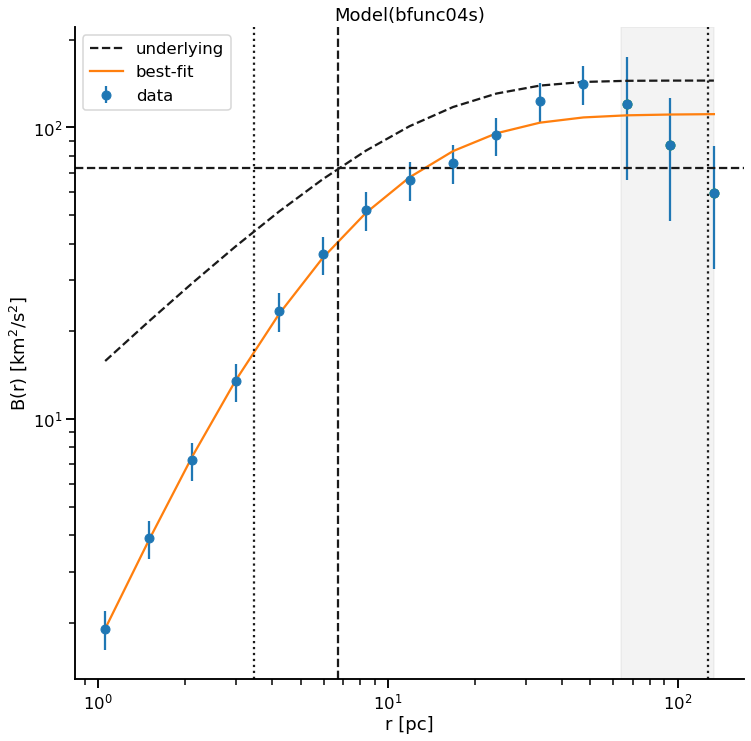

In [169]:
result = result_606
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the underlying model without instrumental effects
Bu = bfunc.bfunc00s(r, result.params["r0"].value, result.params["sig2"].value, result.params["m"].value)
ax.plot(r, Bu, color="k", linestyle="dashed", label="underlying")

# Plot the fit results
result.plot_fit(ax=ax)

# Add in the points not included in fit
ax.plot(r[large_scale], B[large_scale], "o")

# Dotted lines for 2 x rms seeing and for box size
ax.axvline(2 * result.params["s0"].value, color="k", linestyle="dotted")
ax.axvline(result.params["box_size"].value, color="k", linestyle="dotted")

# Dashed lines for best-fit r0 and sig2
ax.axvline(result.params["r0"].value, color="k", linestyle="dashed")
ax.axhline(result.params["sig2"].value, color="k", linestyle="dashed")

# Gray box to indicate the large scale values that are excluded from the fit
ax.axvspan(result.params["box_size"].value / 2, r[-1], color="k", alpha=0.05, zorder=-1)

ax.set(
    xscale = "log",
    yscale = "log",
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
)
sns.despine();


In [170]:
emcee_kws_606 = dict(steps=5000, burn=500, thin=20, workers=16, is_weighted=True,
                 progress=False)
emcee_params_606 = result_606.params.copy()

In [63]:
result_emcee_606 = model.fit(
    data=B[to_fit], r=r[to_fit], weights=weights[to_fit], params=emcee_params_606, method='emcee',
    nan_policy='omit', fit_kws=emcee_kws_606,
)
result_emcee_606

Text(0, 0.5, 'acceptance fraction')

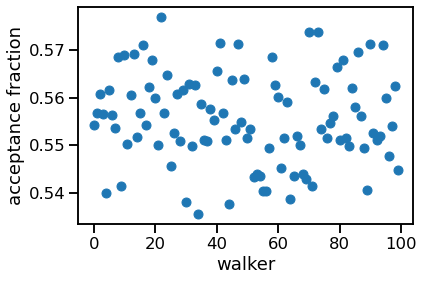

In [64]:
plt.plot(result_emcee_606.acceptance_fraction, 'o')
plt.xlabel('walker')
plt.ylabel('acceptance fraction')

In [65]:
if hasattr(result_emcee_606, "acor"):
    print("Autocorrelation time for the parameters:")
    print("----------------------------------------")
    for i, p in enumerate(result_emcee_606.params):
        try:
            print(f'{p} = {result_emcee_606.acor[i]:.3f}')
        except IndexError:
            pass

Autocorrelation time for the parameters:
----------------------------------------
r0 = 55.823
sig2 = 53.661
m = 54.198
s0 = 55.375


I had to set the `range` parameter on the corner plots because otherwise it included a very long tail on `sig2` and `r0`. I set it to include 99.5% of all the samples for each variable.

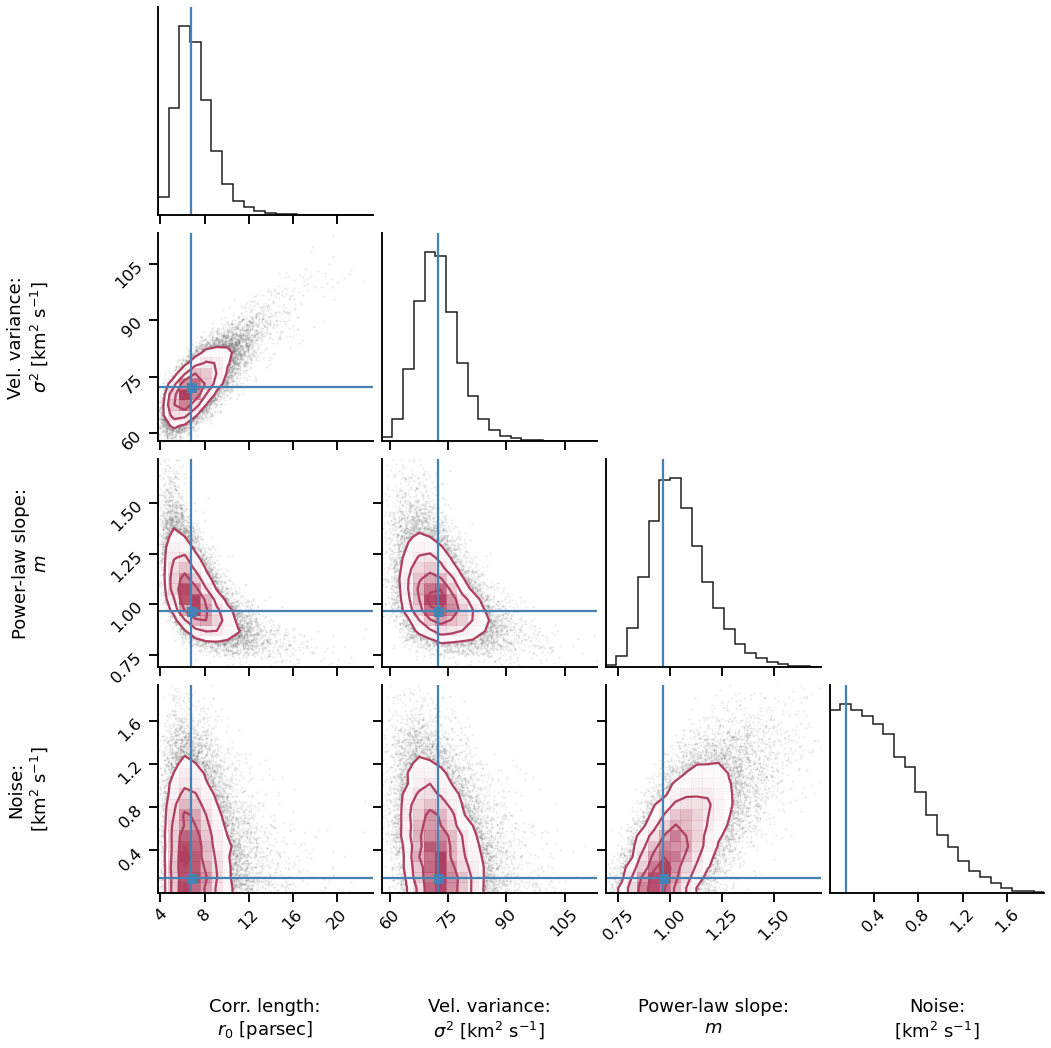

In [171]:
corner_plot(result_emcee_606, result_606, "ngc606");

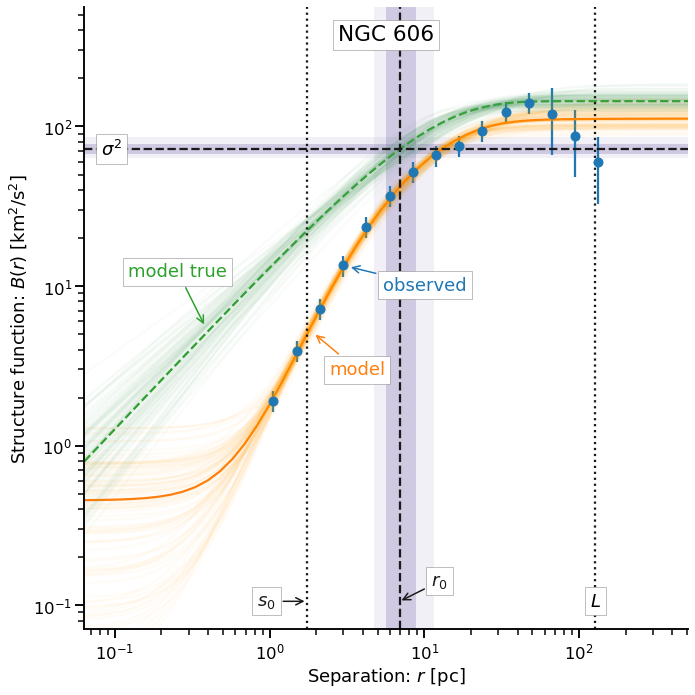

In [172]:
strucfunc_plot(result_emcee_606, r, B, to_fit, "NGC 606", "ngc606")

In [173]:
model = lmfit.Model(bfunc.bfunc04s)

# Correlation length between 1/10 and 2 x box_size
model.set_param_hint("r0", value=0.1 * box_size, min=0.01 * box_size, max=2 * box_size)

# sig2 between 1/4 and 2 x max value of B(r)
model.set_param_hint("sig2", value=0.5 * B.max(), min=0.25 * B.max(), max=2 * B.max())

# m between 0 and 2
model.set_param_hint("m", value=1.0, min=0.0, max=2.0)

# Seeing RMS fixed at FWHM = 1 arcsec
#model.set_param_hint("s0", value=1.0 * pc_per_arcsec / 2.35, vary=False)
model.set_param_hint("s0", value=1.0 * pc_per_arcsec, min=0.1 * pc_per_arcsec, max=1.5 * pc_per_arcsec)

# Noise cannot be much larger than smallest B(r)
model.set_param_hint("noise", value=0.5 * B.min(), min=0.0, max=3 * B.min())

# box_size is fixed
model.set_param_hint("box_size", value=box_size, vary=False)

relative_uncertainty = 0.1
weights = 1.0 / (relative_uncertainty * B)
large_scale = r > 0.5 * box_size
weights[large_scale] /= 3.0
#weights[:3] /= 3.0

to_fit = np.ones(B.shape, dtype=bool)
result_606b = model.fit(B[to_fit], weights=weights[to_fit], r=r[to_fit], method="nelder")
result_606b

For this model I have to increase the number of steps in the walker because the correlation time is longer.

In [174]:
emcee_kws_606b = dict(steps=25000, burn=1000, thin=40, workers=16, is_weighted=True, progress=False)
emcee_params_606b = result_606b.params.copy()

In [79]:
result_emcee_606b = model.fit(
    data=B[to_fit], r=r[to_fit], weights=weights[to_fit], params=emcee_params_606b, method='emcee',
    nan_policy='omit', fit_kws=emcee_kws_606b,
)
result_emcee_606b

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 500;
tau: [651.14658421 706.85677913 249.63667894 642.16350745 200.82228278]


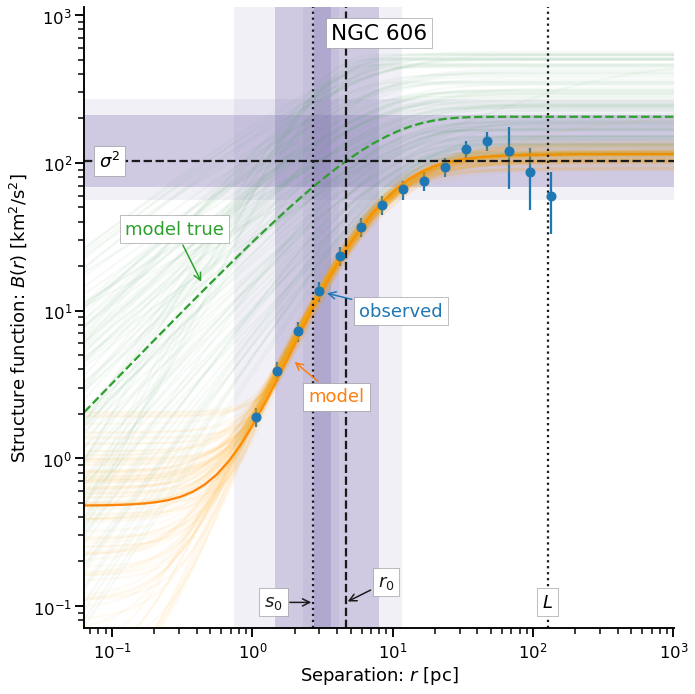

In [192]:
strucfunc_plot(result_emcee_606b, r, B, to_fit, "NGC 606", "ngc606b");

We have to do lots of manual tweaking of the ranges to get a sensible corner plot. In particular, we are including only 95% of the total spread in `r0`.

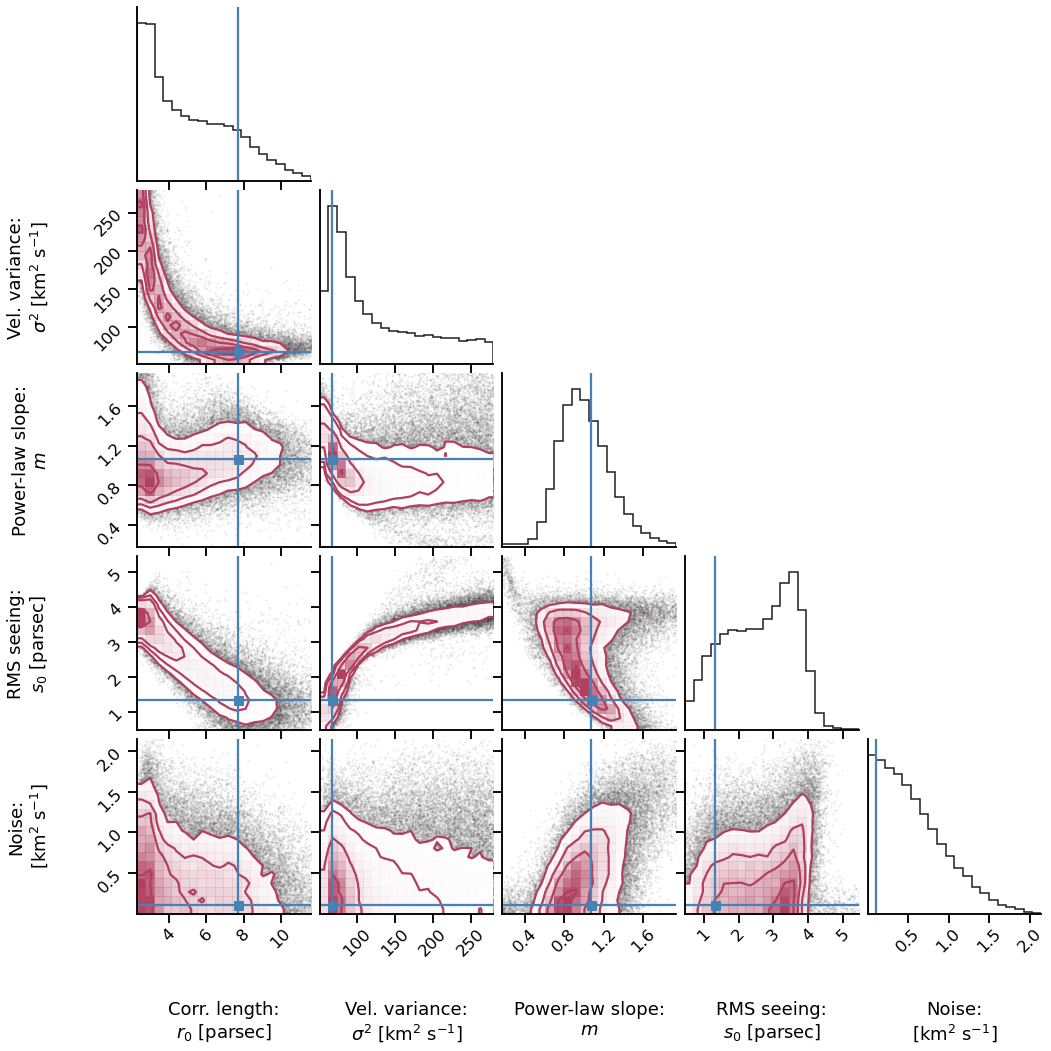

In [184]:
corner_plot(result_emcee_606b, result_606b, "ngc606b", data_ranges=[0.95, 0.99, 0.995, 0.995, 0.999]);

So this seems to be working OK now with the freely floating seeing.  Note that the seeing posterior distribution is bimodal, with it either being around 1.5 pc (as with the LM solution) or around 3.5 pc.  The latter is a FWHM of 2 arcsec, which is probably too high.  But if the seeing truly were so high, then the model has to have much smaller `r0` and much larger `sig2`.

In [161]:
result_606b.params

name,value,standard error,relative error,initial value,min,max,vary
r0,227.512017,260.910840,(114.68%),12.705996954518719,1.27059970,254.119939,True
sig2,46.2786711,52.0378934,(112.44%),11.801098511021321,5.90054926,47.2043940,True
m,1.32456320,0.06946524,(5.24%),1.0,0.00000000,2.00000000,True
s0,0.89500395,0.31667318,(35.38%),4.072434921320102,0.40724349,6.10865238,True
noise,4.1873e-10,0.00685205,(1636404275.29%),0.015019185057242335,0.00000000,0.09011511,True
box_size,127.059970,0.00000000,(0.00%),127.05996954518719,-inf,inf,False


In [162]:
result_emcee_606b.params

name,value,standard error,relative error,initial value,min,max,vary
r0,4.63682919,2.60604478,(56.20%),7.7246377988858566,1.27059970,254.119939,True
sig2,102.464001,70.7121223,(69.01%),66.43024010709266,35.2236364,281.789091,True
m,0.98598982,0.25566531,(25.93%),1.0673800628778578,0.00000000,2.00000000,True
s0,2.71465639,1.10624040,(40.75%),1.329829541950831,0.40724349,6.10865238,True
noise,0.47734965,0.42338738,(88.70%),0.11013238565436304,0.00000000,5.71735560,True
box_size,127.059970,,(88.70%),127.05996954518719,-inf,inf,False


In [188]:
2.355 * 2.7 / pc_per_arcsec

1.5613509172882885